## Beampattern and Directivity
The backprojection imaging algorithm uses the measured antenna gains as follows:
$$
I(\vec r) = \sum_{k=0}^{K-1}g^*_{\text{meas},k}(\theta) \sum_{m=0}^{M-1}e^{+j\beta\tau_k(\vec r)mT_s}y_k(m)
$$
This can be interpreted as location-dependend beamforming being performed on a transformed input signal $\mathbf{\tilde y}$
$$
I(\vec r) = \mathbf g^H(\vec r) \cdot \mathbf{\tilde y}(\vec r), \\
\text{where } \tilde y_k(\vec r) = \sum_{m=0}^{M-1}e^{+j\beta\tau_k(\vec r)mT_s}y_k(m).

$$

 Thus, the beampattern for the beamformer employed for a given location $\vec r_0$ can be computed as
$$
BP(\vec r) = \mathbf g^H(\vec r_0) \cdot \mathbf g(\vec r).
$$


In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
import torch, pickle, numpy


# setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
nfft = 2**18
pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_010_000_056.0, 80_289_505_280.0
t_start, t_end =  2e-6, 66.1e-6
# ramp_slope = (f_start-f_end) / (t_start-t_end)
ramp_slope = 65_950.2e9
hertz_per_meter = ramp_slope / lightspeed
print(f_start-f_end)
bins_per_meter = nfft / maxdist
fs = 22e6
Ts = 1/fs
beta = 2*pi*ramp_slope

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
dists = [2.143, 8.099, 18.016, 32.284]

angles = [pickle.load(open(folder+f'a{int(dist):02d}_angle.pkl', 'rb')) for dist in dists]
degs = [list(map(lambda a : round(a*180/pi - 90), angle)) for angle in angles]
l_degs = [[deg.index(a) for a in sorted(set(deg)) if -60<a<60] for deg in degs]
l_sels = [[l for l,a in enumerate(angle) if -50<180/pi*a-90<50] for angle in angles]
angles_filtered = [[angle[l] for l in l_deg] for angle,l_deg in zip(angles,l_degs)]
#angles_filtered = [[angle[l] for l in l_sel] for angle,l_sel in zip(angles,l_sels)]
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']

folder = '/home/dgotzens/scripts/3.1_imaging/measured_gains/'
with open(folder+'gains.pkl', 'rb') as f:
    gains = pickle.load(f)
with open(folder+'taus.pkl', 'rb') as f:
    taus = pickle.load(f)

cpu
-4279505224.0


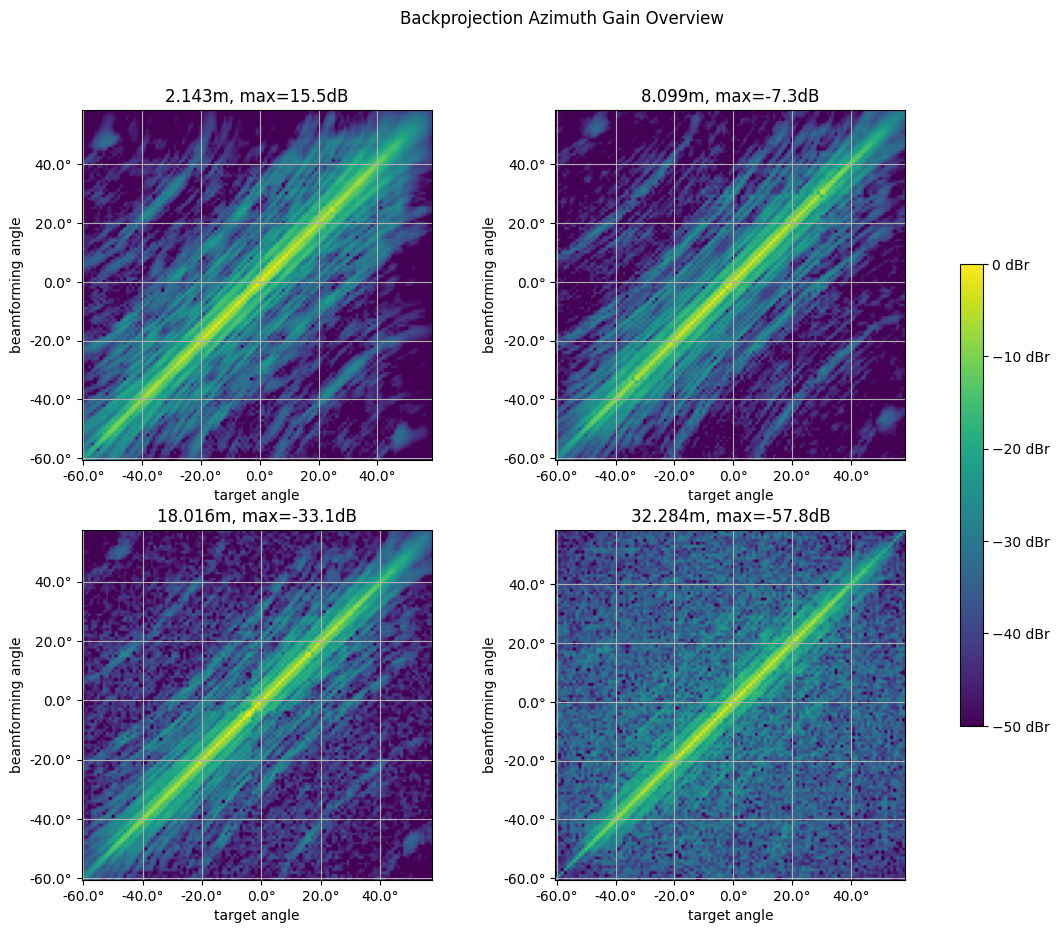

In [6]:
fig,axes = plt.subplots(2,2)
to_dbr = lambda x: 20*torch.log10(x.abs()/x.abs().max())
for ax, dist, angle, gain in zip(axes.flat, dists, angles_filtered,gains):
    ax.set_title(f'{dist}m, max={20*gain.H.mm(gain).abs().log10().max():.1f}dB')
    im=ax.imshow(to_dbr(gain.H.mm(gain)), origin='lower', vmin=-50, vmax=0)
    L=len(angle)
    ax.set_yticks(range(0,L,20), [f'{round(180/pi*angle[l]-90,-1)}°' for l in range(0,L,20)])
    ax.set_ylabel('beamforming angle')
    ax.set_xticks(range(0,L,20), [f'{round(180/pi*angle[l]-90,-1)}°' for l in range(0,L,20)])
    ax.set_xlabel('target angle')
    ax.grid()
fig.set_size_inches(14,10)
fig.suptitle('Backprojection Azimuth Gain Overview')
fig.colorbar(im,ax=axes.ravel(), shrink=0.6, format=EngFormatter('dBr'))

Text(0.5, 0.98, 'Backprojection Azimuth Gain')

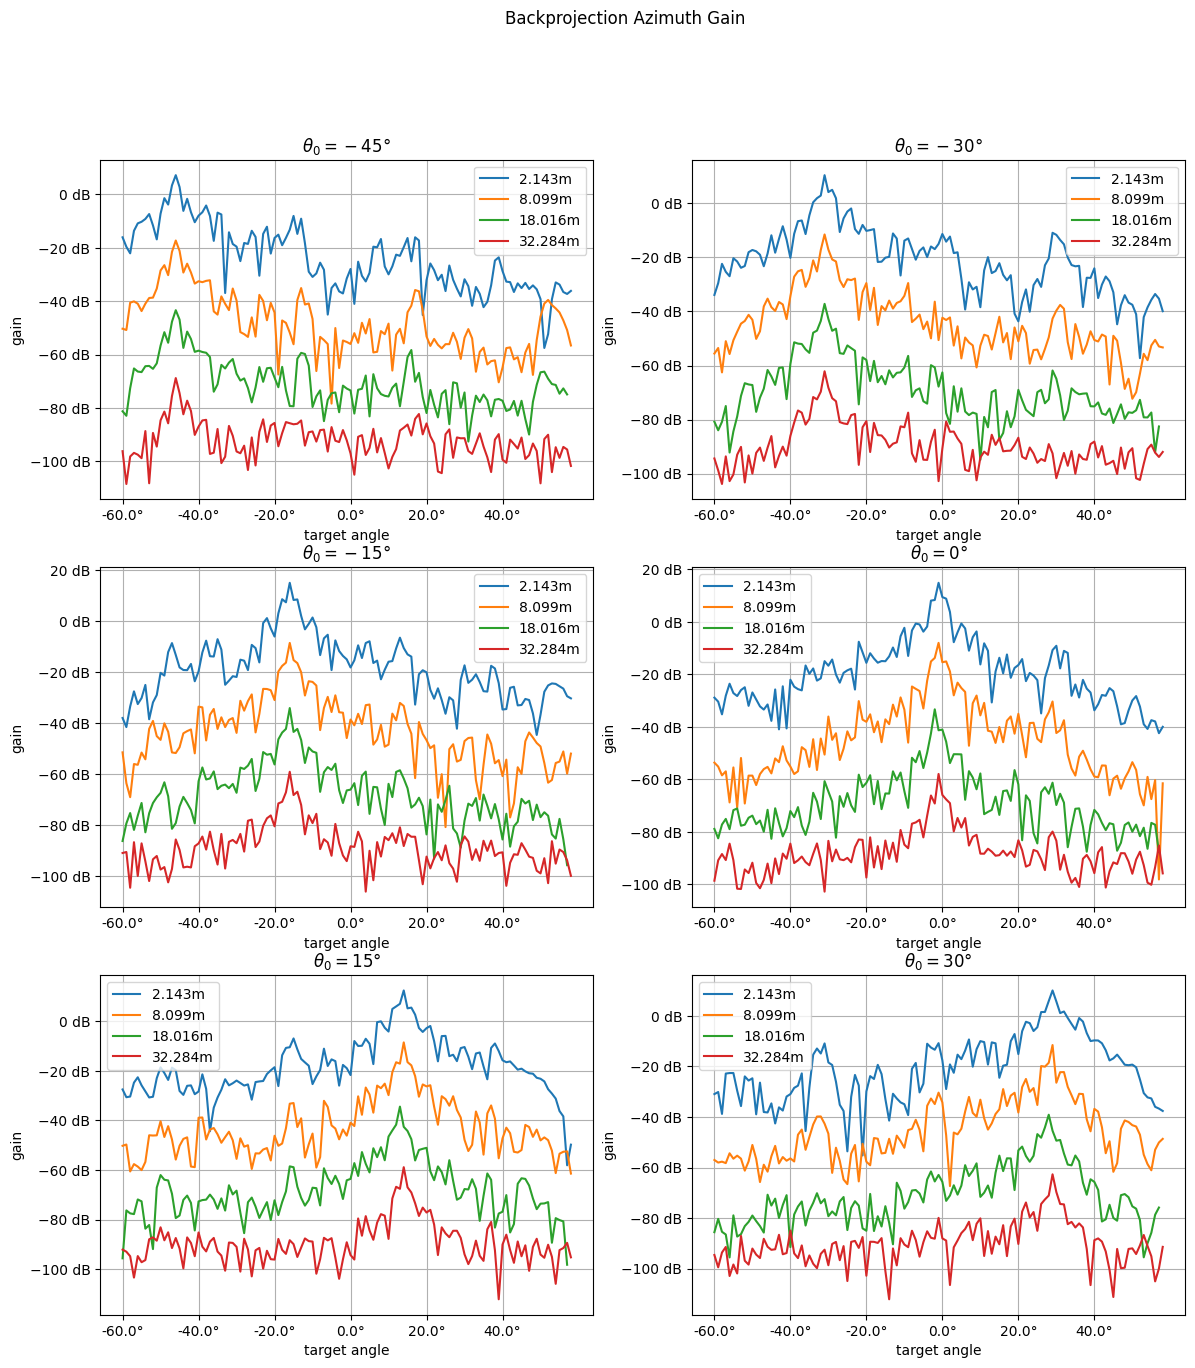

In [7]:
fig,axes = plt.subplots(3,2)
for a,ax in zip(range(-45,46,15), axes.flat):
    for dist, angle, gain in zip(dists, angles_filtered,gains):
        l = list(map(lambda a: round(180/pi*a-90), angle)).index(a)
        ax.plot(20*(gain.H.mm(gain)).abs().log10()[:,l], label=f'{dist}m')
        #ax.plot((gain.H.mm(gain)).abs()[:,l], label=f'{dist}m')
    ax.set_xticks(range(0,L,20), [f'{round(180/pi*angle[l]-90,-1)}°' for l in range(0,L,20)])
    ax.set_xlabel('target angle')
    ax.set_ylabel('gain')
    ax.yaxis.set_major_formatter(EngFormatter('dB'))
    ax.grid()
    ax.legend()
    ax.set_title(f'$\\theta_0={a}°$')
fig.set_size_inches(14,15)
fig.suptitle('Backprojection Azimuth Gain')
